In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Datasets',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_9468\3882198774.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Datasets',


In [5]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [6]:
len(dataset)

48

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 2 0 0 2 0 0 0 2 2 0 2 2 0 2 2 0 0 0 2 0 0 1 0 2 2 0 2 2]


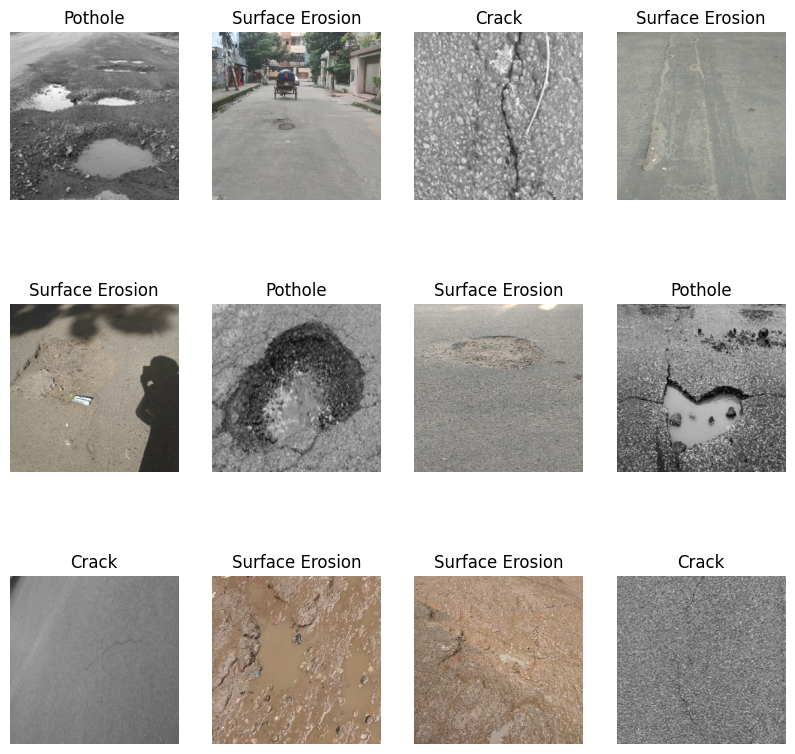

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [10]:
train_data = dataset.take(38)
len(train_data)

38

In [11]:
test_data = dataset.skip(38)
len(test_data)

10

In [12]:
validation_size = 0.1
len(dataset)*validation_size

4.800000000000001

In [13]:
validation_data  = test_data.take(4)
len(validation_data)

4

In [14]:
test_data = test_data.skip(4)
len(test_data)

6

In [15]:
# Dataset split function
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds


In [16]:
train_data, validation_data, test_data = get_dataset_partition(dataset)

In [17]:
len(train_data)
len(validation_data)
len(test_data)

6

In [18]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [21]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3555 - loss: 1.0920 - val_accuracy: 0.3852 - val_loss: 1.1642
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4479 - loss: 1.0736 - val_accuracy: 0.5000 - val_loss: 0.9342
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5215 - loss: 0.9524 - val_accuracy: 0.5164 - val_loss: 0.9030
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5384 - loss: 0.9263 - val_accuracy: 0.5410 - val_loss: 0.8800
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 933ms/step - accuracy: 0.5894 - loss: 0.8928 - val_accuracy: 0.5164 - val_loss: 0.8768
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 925ms/step - accuracy: 0.5672 - loss: 0.8710 - val_accuracy: 0.5410 - val_loss: 0.9130
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 915ms/step - accuracy: 0.5651 - loss: 0.8557 - val_accuracy: 0.5820 - val_loss: 0.8388
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 929ms/step - accuracy: 0.6071 - loss: 0.8290 - val_accuracy: 0.5656

In [25]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.8229 - loss: 0.4426


[0.4241275489330292, 0.8125]

In [26]:
model.save("Trained Model/CNN.h5")

In [27]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
history.history['accuracy']

[0.4033057987689972,
 0.4925619959831238,
 0.5330578684806824,
 0.5694214701652527,
 0.56611567735672,
 0.5685950517654419,
 0.5760330557823181,
 0.5842975378036499,
 0.6380165219306946,
 0.6776859760284424,
 0.6876032948493958,
 0.6966941952705383,
 0.6925619840621948,
 0.699999988079071,
 0.7239669561386108,
 0.6991735696792603,
 0.7305785417556763,
 0.7388429641723633,
 0.7413223385810852,
 0.7429752349853516,
 0.7355371713638306,
 0.7438016533851624,
 0.7586776614189148,
 0.7446280717849731,
 0.7793388366699219,
 0.7760330438613892,
 0.784297525882721,
 0.7966942191123962,
 0.7677686214447021,
 0.7669421434402466,
 0.7884297370910645,
 0.7776859402656555,
 0.7983471155166626,
 0.7851239442825317,
 0.7636363506317139,
 0.813223123550415,
 0.7900826334953308,
 0.78925621509552,
 0.7933884263038635,
 0.7983471155166626,
 0.8008264303207397,
 0.800000011920929,
 0.8090909123420715,
 0.8008264303207397,
 0.808264434337616,
 0.8099173307418823,
 0.8371900916099548,
 0.8074380159378052,
 

In [30]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
F1 Score (macro): 0.8122486122486122
F1 Score (weighted): 0.8116980616980617

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.88      0.70      0.78        60
        Pothole       0.87      0.82      0.85        57
Surface Erosion       0.74      0.89      0.81        75

       accuracy                           0.81       192
      macro avg       0.83      0.81      0.81       192
   weighted avg       0.82      0.81      0.81       192



In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

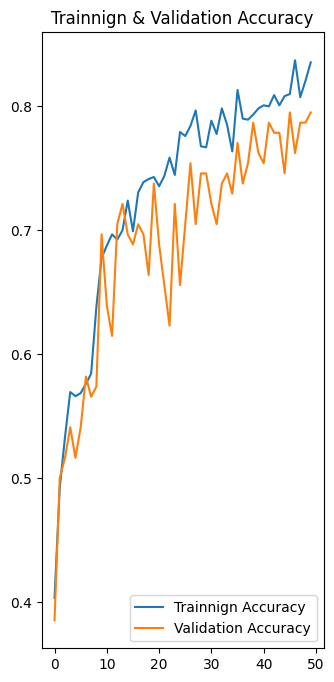

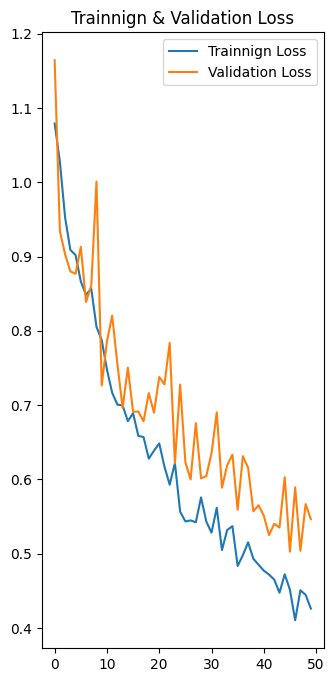

In [32]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [33]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8132 - loss: 0.4148


[0.4241274893283844, 0.8125]

First image to predict
First image actual label:  Surface Erosion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicted Label:  Surface Erosion


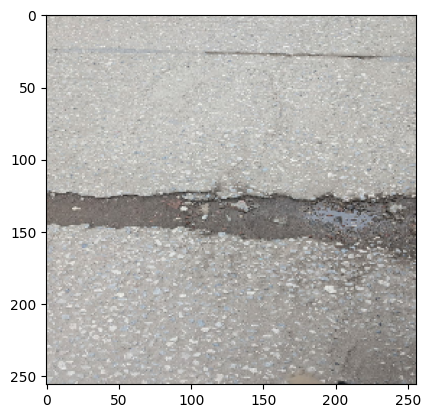

In [34]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->99.22000122070312 Light:-> Normal lighting
Confidence:->76.06999969482422 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->61.939998626708984 Light:-> Normal lighting
Confidence:->94.7300033569336 Light:-> Normal lighting
Confidence:->86.93000030517578 Light:-> Normal lighting
Confidence:->81.7300033569336 Light:-> Normal lighting
Confidence:->81.33999633789062 Light:-> Normal lighting
Confidence:->99.98999786376953 Light:-> Normal lighting


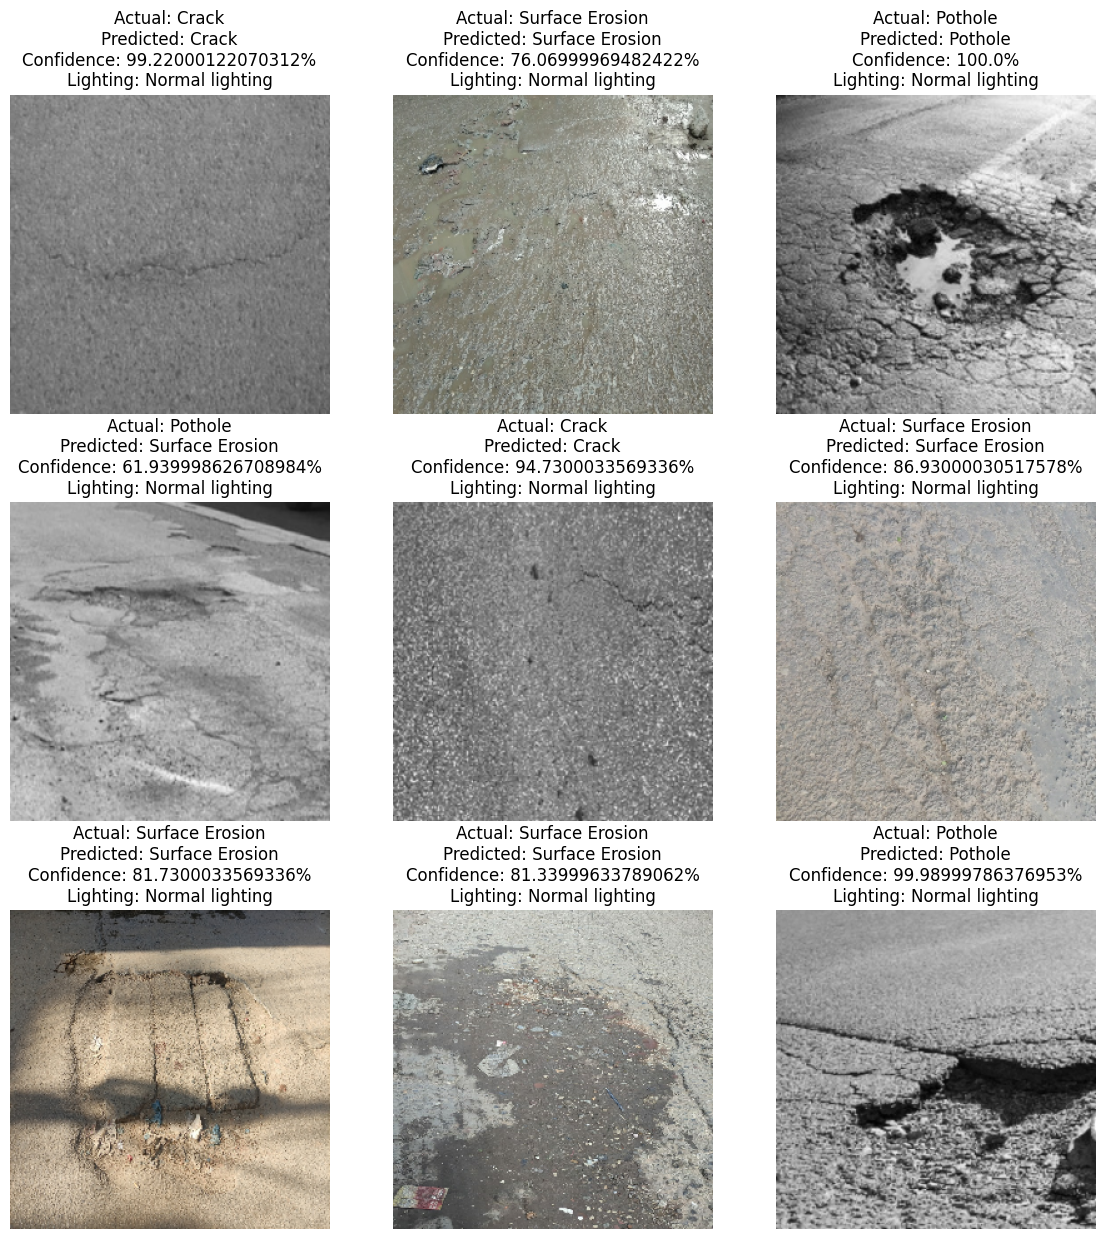

In [36]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [39]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Pothole, Confidence: 99.98999786376953


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


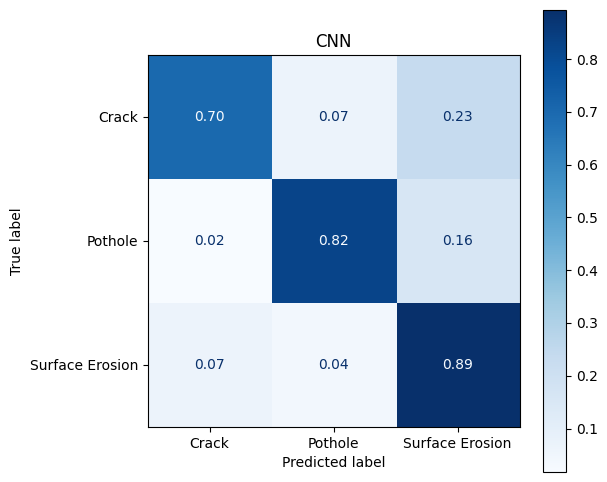

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("CNN")
plt.savefig("confusion_matrix_CNN.png", dpi=300, bbox_inches='tight')
plt.show()
